In [1]:
import matplotlib.pyplot as plt
from albumentations import Flip, ShiftScaleRotate, RandomRotate90, RandomCrop
from datasets import HearingDataset,HearingDataset_Fast,OceletDataset,OceletDataset_Fast
import os 
import torch
import numpy as np
os.environ['CUDA_VISIBLE_DEVICES'] = "4"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
torch.set_num_threads(3)


/home/wzy/.conda/envs/general/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module '_watershed_cy' does not match runtime version 3.7
  return f(*args, **kwds)


#### Training Process

In [2]:
import glob,os
from trainval import trainval
import matplotlib.pyplot as plt
from haven import haven_utils as hu

In [3]:
exp_dict = hu.load_json('Experiment_Exp/exp_config_mynet_1.json')
exp_dict["batch_size"] = 1
exp_dict["max_epoch"] = 10

datadir = '/data114_1/ocelot2023_v0.1.2' 

In [4]:
import random
import albumentations as A 
data_transform = A.Compose([A.Flip(p=0.3),
                            # A.Affine(p=0.3),
                            # A.Rotate(p=0.3),
                            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3),
                            A.GaussianBlur(3, p=0.3),
                            A.GaussNoise(30, p=0.3)],
                            keypoint_params=A.KeypointParams(format='xy'),
                            additional_targets={'mask0': 'mask',
                                                'tissue_img':'mask',
                                                'tissue_mask':'mask',
                                                })
    
# random.seed(20201009)
random_seed = random.randint(0, 20201009)
# plt.imshow(train_set[0]['images'].numpy().transpose(1,2,0))

/home/wzy/.conda/envs/general/lib/python3.7/site-packages/albumentations/augmentations/blur/transforms.py:185: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  "blur_limit and sigma_limit minimum value can not be both equal to 0. "


In [5]:
train_set = OceletDataset(data_dir=datadir,
                            n_classes=exp_dict["n_classes"],
                            transform=data_transform,
                            option="train",
                            random_seed=random_seed,
                        #    obj_option=exp_dict["obj"],
                         #    bkg_option=exp_dict["bkg"]
                            )
# train_set = OceletDataset_Fast(data_dir=datadir,
#                             n_classes=exp_dict["n_classes"],
#                             transform=data_transform,
#                             option="train",
#                             random_seed=random_seed,
#                             patch_size = exp_dict["patch_size"]
#                         #    obj_option=exp_dict["obj"],
#                          #    bkg_option=exp_dict["bkg"]
#                             )

In [6]:
idx = 3
image = train_set[idx]['images'].numpy().transpose(1,2,0)
gt = train_set[idx]['gt'].numpy()
heatmap = train_set[idx]['heatmap'].numpy()
tissue_img = train_set[idx]['tissue_img'].numpy().transpose(1,2,0)
tissue_mask = train_set[idx]['tissue_mask'].numpy()
# pair_map = train_set[idx]['pair_map'].numpy()

x = train_set[idx]['roi_loc'][1]
y = train_set[idx]['roi_loc'][0]

fig,axes = plt.subplots(2,3, figsize=(30,10))
axes[0,0].imshow(image)
axes[0,1].imshow(gt)
axes[0,2].imshow(heatmap)
axes[1,0].imshow(tissue_img[x-128:x+128,y-128:y+128])
axes[1,1].imshow(tissue_mask)
axes[1,2].imshow(tissue_img)

In [ ]:
# folddir_10 = glob.glob(os.path.join(datadir, '*_fold'))

# for folddir in folddir_10:
#     savedir_base = os.path.join(folddir,'Resu lt')
#     os.makedirs(savedir_base,exist_ok=True)


savedir_base = "./Result" 
os.makedirs(savedir_base,exist_ok=True)
trainval(exp_dict, savedir_base, datadir, reset=False, num_workers=8)

#### 在测试集上进行测试

In [46]:
import torch 
from torch.utils.data import DataLoader
import albumentations as A
import models
from datasets import OceletDataset
from haven import haven_utils as hu
import tqdm 
import cv2

datadir = '/data114_1/ocelot2023_v0.1.2' 
data_transform = A.Compose([
                # A.Flip(p=0.3),
                # A.Affine(p=0.3),
                # A.Rotate(p=0.3),
                A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3),
                A.GaussianBlur(3, p=0.3),
                A.GaussNoise(30, p=0.3)],
                keypoint_params=A.KeypointParams(format='xy'),
                additional_targets={'mask0': 'mask',
                                    'tissue_img':'mask',
                                    'tissue_mask':'mask',
                                    })
                                    
test_transform = A.Compose([A.Resize(1024, 1024)],
                            keypoint_params=A.KeypointParams(format='xy'),
                            additional_targets={'mask0': 'mask',
                                                'tissue_img':'mask',
                                                'tissue_mask':'mask',
                                                })
test_set = OceletDataset(data_dir=datadir,
                        n_classes=exp_dict["n_classes"],
                        transform=test_transform,
                        option="test")

test_loader = DataLoader(test_set,
                        batch_size=1,
                        num_workers=4)


model_dir = 'Result/v4'
save_dir = 'eval'
model = models.get_model(exp_dict['model'], exp_dict=exp_dict, train_set=test_set).cuda()
model.load_state_dict(hu.torch_load(os.path.join(model_dir, "model_best.pth")))    

In [47]:
for i, batch in enumerate(tqdm.tqdm(test_loader)):
    cell_images = batch["images"].cuda()
    cell_masks = batch["gt"].long().cuda()
    tissue_img = batch["tissue_img"].cuda()
    tissue_masks = batch["tissue_mask"].cuda()
    roi_loc = batch["roi_loc"].cuda()

    cell_logits,tissue_logits = model.model_base.predict(cell_images,tissue_img,roi_loc)
    prob = cell_logits.sigmoid()
    seg = torch.argmax(prob, dim=1)
    
    cv2.imwrite(os.path.join(save_dir, 'predict/masks', '{}.png'.format(i)),seg[0].detach().cpu().numpy())
    cv2.imwrite(os.path.join(save_dir, 'gt/masks', '{}.png'.format(i)),cell_masks[0].detach().cpu().numpy())
    

100%|██████████| 40/40 [00:12<00:00,  3.19it/s]


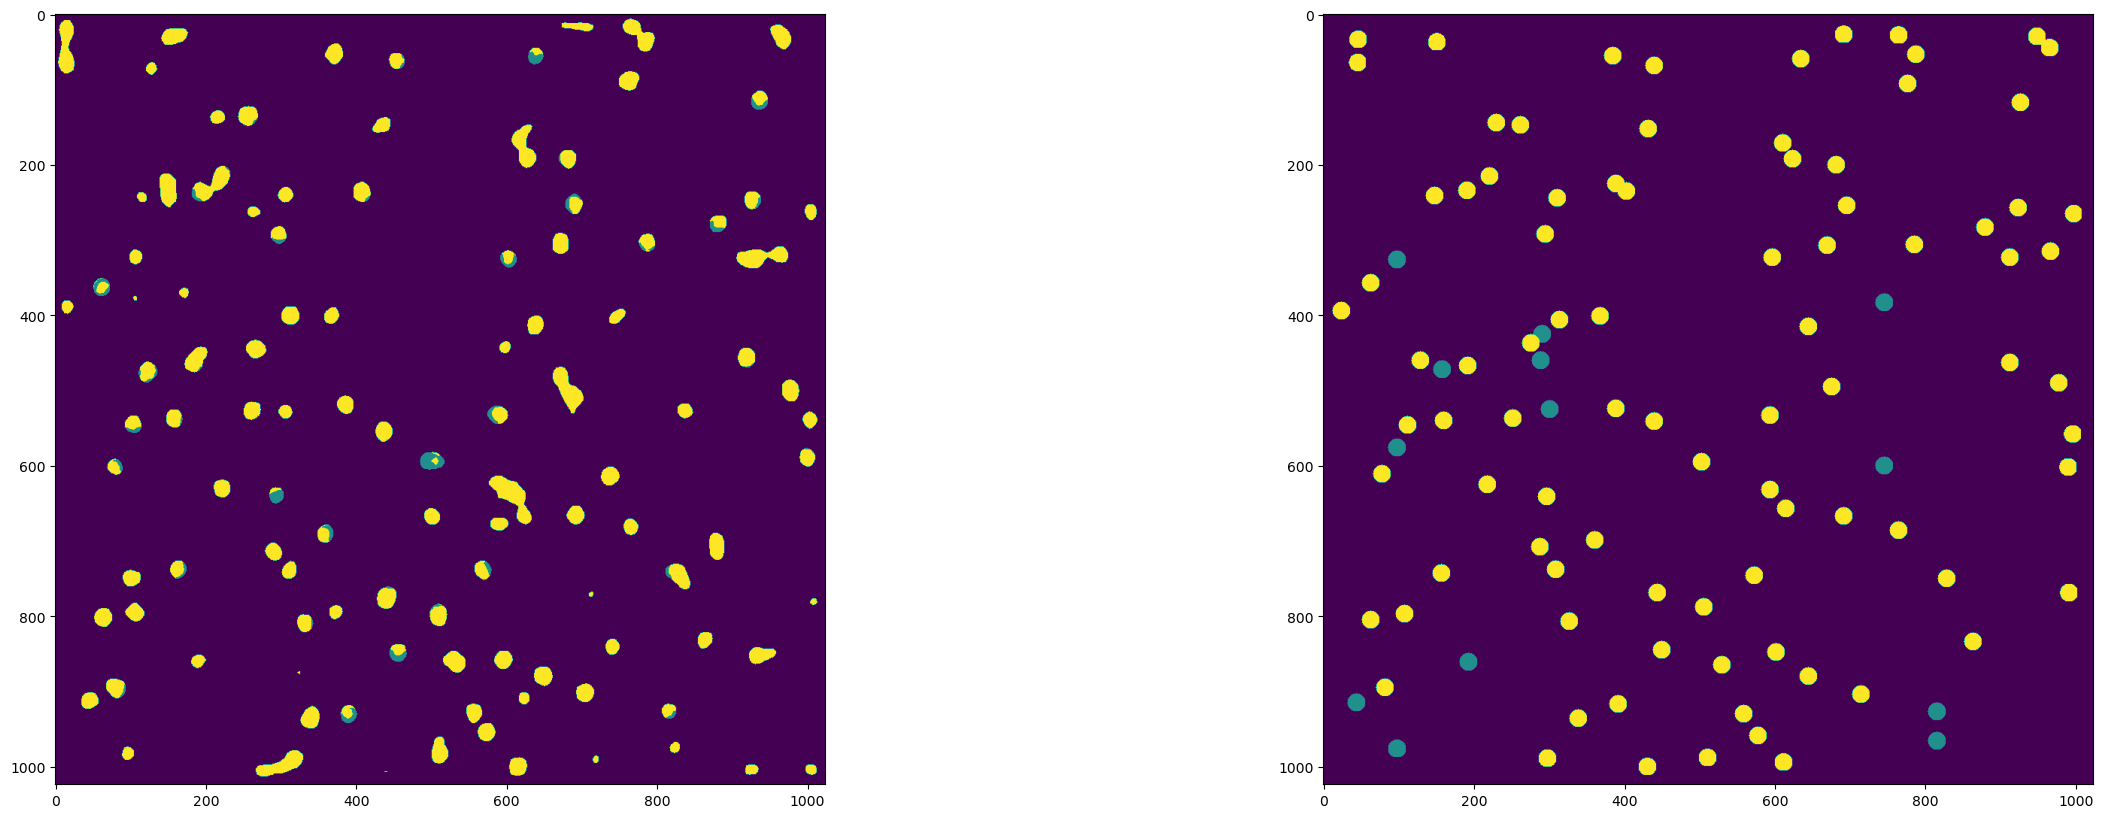

In [48]:
predict = cv2.imread('eval/predict/masks/10.png')[:,:,0]
gt = cv2.imread('eval/gt/masks/10.png')[:,:,0]

fig,axes = plt.subplots(1,2, figsize=(30,10))

axes[0].imshow(predict)
axes[1].imshow(gt)

In [49]:
!python eval/mask2csv.py
!python eval/convert_pred_csvs_to_json.py -d /data114_1/wzy/homework/code/eval -s test -m predict
!python eval/convert_pred_csvs_to_json.py -d /data114_1/wzy/homework/code/eval -s test -m gt
!python eval/eval.py

eval/mask2csv.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lb'][index]=image[row['y']][row['x']]
eval/mask2csv.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lb'][index]=image[row['y']][row['x']]
images num:40
JSON file saved in /data114_1/wzy/homework/code/eval/predict/cell_predict_test.json
images num:40
JSON file saved in /data114_1/wzy/homework/code/eval/gt/cell_gt_test.json
{'Pre/BC': 0.4201, 'Rec/BC': 0.1265, 'F1/BC': 0.1945, 'Pre/TC': 0.1491, 'Rec/TC': 0.8417, 'F1/TC': 0.2533, 'mF1': 0.22390000000000002}
